In [1]:
import pandas as pd
import numpy as np
import ast
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, roc_auc_score, precision_recall_curve, auc
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.optim as optim
import wandb
from torch.optim.lr_scheduler import StepLR



In [2]:
# test = pd.read_csv("../model_dev/densenet_data/densenet_all_test_embeddings.csv", quotechar='"', on_bad_lines='skip')
# train = pd.read_csv("../model_dev/densenet_data/densenet_all_train_embeddings.csv", quotechar='"', on_bad_lines='skip')
# valid = pd.read_csv("../model_dev/densenet_data/densenet_all_valid_embeddings.csv", quotechar='"', on_bad_lines='skip')

test_initial = pd.read_csv("/home/research/svea/ml_project/densenet_test_embeddings.csv", quotechar='"', on_bad_lines='skip')
train_initial = pd.read_csv("/home/research/svea/ml_project/densenet_train_embeddings.csv", quotechar='"', on_bad_lines='skip')
valid_initial = pd.read_csv("/home/research/svea/ml_project/densenet_valid_embeddings.csv", quotechar='"', on_bad_lines='skip')

print(test_initial.columns)
test_initial.head()

Index(['path_to_image', 'path_to_dcm', 'age', 'sex', 'race', 'insurance_type',
       'No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly',
       'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia',
       'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other',
       'Fracture', 'Support Devices', 'embeddings'],
      dtype='object')


,path_to_image,path_to_dcm,age,sex,race,insurance_type,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,...,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,embeddings
0,train/patient47347/study3/view1_frontal.jpg,train/patient47347/study3/view1_frontal.dcm,78.0,1,0,1,0,0,1,0,...,1,0,0,1,0,1,0,1,1,"[0.0029132624622434378, 0.1020001769065857, 0...."
1,train/patient37527/study12/view1_frontal.jpg,train/patient37527/study12/view1_frontal.dcm,63.0,0,1,2,0,0,0,0,...,0,0,0,0,0,1,0,0,0,"[0.0014348188415169716, 0.0543656125664711, 0...."
2,train/patient41208/study9/view1_frontal.jpg,train/patient41208/study9/view1_frontal.dcm,70.0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,"[0.001982336398214102, 0.040021587163209915, 0..."
3,train/patient39357/study1/view1_frontal.jpg,train/patient39357/study1/view1_frontal.dcm,79.0,1,1,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,"[0.001741771469824016, 0.0560498870909214, 0.1..."
4,train/patient31982/study4/view1_frontal.jpg,train/patient31982/study4/view1_frontal.dcm,67.0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,"[9.678312198957428e-05, 0.12247737497091293, 0..."


In [3]:
test_initial['embeddings'] = test_initial['embeddings'].apply(ast.literal_eval)

In [4]:
valid_initial['embeddings'] = valid_initial['embeddings'].apply(ast.literal_eval)

In [5]:
train_initial['embeddings'] = train_initial['embeddings'].apply(ast.literal_eval)

In [6]:
test = test_initial.drop(columns=['path_to_image', 'path_to_dcm'])
train = train_initial.drop(columns=['path_to_image', 'path_to_dcm'])
valid = valid_initial.drop(columns=['path_to_image', 'path_to_dcm'])


In [7]:
initial_size = test.shape[0] 
test = test[test['embeddings'].str.len() > 10]
final_size = test.shape[0] 
print(f'Number of test removed rows = {initial_size - final_size}')

initial_size = train.shape[0] 
train = train[train['embeddings'].str.len() > 10]
final_size = train.shape[0] 
print(f'Number of train removed rows = {initial_size - final_size}')

initial_size = test.shape[0] 
valid = valid[valid['embeddings'].str.len() > 10]
final_size = test.shape[0] 
print(f'Number of valid removed rows = {initial_size - final_size}')

Number of test removed rows = 51
Number of train removed rows = 67
Number of valid removed rows = 0


In [8]:
a = 70
test['age'] = (test['age'] >= a).astype(int)
valid['age'] = (valid['age'] >= a).astype(int)
train['age'] = (train['age'] >= a).astype(int)

In [9]:
import torch

# Extract the embeddings by turning the pandas series into a list and then into a tensor
train_embeddings = torch.tensor(np.array(train['embeddings'].tolist()), dtype=torch.float32)
valid_embeddings = torch.tensor(np.array(valid['embeddings'].tolist()), dtype=torch.float32)
test_embeddings = torch.tensor(np.array(test['embeddings'].tolist()), dtype=torch.float32)

# The TensorDataset stores the tensors and allows easy access to the data in batches.
#train_loader: Data is loaded from the train_dataset in batches of size 128. The order of the data is randomly shuffled (shuffle=True) at each epoch to ensure that the model does not learn dependencies on the order.
#valid_loader:Data is loaded from the valid_dataset in batches of size 128. The order of the data remains fixed (shuffle=False) because validation data is often evaluated in the original order.
train_dataset = torch.utils.data.TensorDataset(train_embeddings)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)

valid_dataset = torch.utils.data.TensorDataset(valid_embeddings)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=128, shuffle=False)


In [10]:
class Autoencoder(nn.Module): 
    def __init__(self, input_dim=1024, latent_dim=128):
        super(Autoencoder, self).__init__() # inherits arent class (nn.Module) from which your Autoencoder class inherits. It initializes PyTorch's internal mechanisms for managing model parameters and registering layers.
        # Encoder Here, we define the Encoder, which progressively transforms the input data (x) through multiple transformations into a compressed latent space (z). The encoder reduces the input dimensionality from 1024 to 128.
        self.encoder = nn.Sequential( #With nn.Sequential, you don't need to explicitly define how data moves from one layer to the next in the forward pass—it automatically handles this for you.
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dim)
        )
        # Decoder Here, we are defining the Decoder portion of the Autoencoder using nn.Sequential. The Decoder is responsible for reconstructing the input data x^ from the latent representation z. Essentially, it reverses the dimensionality reduction performed by the Encoder and attempts to recover the original structure of the data.
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim),
            nn.Sigmoid()  # For reconstruction in [0, 1]
        )
    
    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return latent, reconstructed

# Modellinitialisierung
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
autoencoder = Autoencoder(input_dim=1024, latent_dim=128).to(device)


In [11]:
# Hyperparameter
learning_rate = 0.0005
epochs = 50

# Optimizer and loss function : MSE is a natural choice because it penalizes larger differences more heavily, encouraging the model to reduce significant reconstruction errors.
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)

# Training-loop
for epoch in range(epochs):
    autoencoder.train()
    train_loss = 0.0
    for batch in train_loader: #loop over batches
        data = batch[0].to(device)  # Input data: Moves the input data from the CPU to the device (GPU or CPU) where the model is located.
        optimizer.zero_grad() #Clears the previously accumulated gradients of the model's parameters.
        
        # forward propagatoin
        latent, reconstructed = autoencoder(data)
        loss = criterion(reconstructed, data)  # MSE-Loss
        
        # backwards propagation and optimizing
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    # Validating
    autoencoder.eval()
    valid_loss = 0.0
    with torch.no_grad(): #This disables gradient computation during validation.
        for batch in valid_loader: #Iterate Over Validation Batches
            data = batch[0].to(device)
            latent, reconstructed = autoencoder(data)
            loss = criterion(reconstructed, data)
            valid_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss/len(train_loader):.4f}, Valid Loss: {valid_loss/len(valid_loader):.4f}")


Epoch [1/50], Train Loss: 0.0119, Valid Loss: 0.0033
Epoch [2/50], Train Loss: 0.0023, Valid Loss: 0.0018
Epoch [3/50], Train Loss: 0.0016, Valid Loss: 0.0013
Epoch [4/50], Train Loss: 0.0013, Valid Loss: 0.0012
Epoch [5/50], Train Loss: 0.0012, Valid Loss: 0.0011
Epoch [6/50], Train Loss: 0.0010, Valid Loss: 0.0010
Epoch [7/50], Train Loss: 0.0009, Valid Loss: 0.0009
Epoch [8/50], Train Loss: 0.0009, Valid Loss: 0.0008
Epoch [9/50], Train Loss: 0.0008, Valid Loss: 0.0008
Epoch [10/50], Train Loss: 0.0008, Valid Loss: 0.0007
Epoch [11/50], Train Loss: 0.0007, Valid Loss: 0.0007
Epoch [12/50], Train Loss: 0.0007, Valid Loss: 0.0007
Epoch [13/50], Train Loss: 0.0007, Valid Loss: 0.0007
Epoch [14/50], Train Loss: 0.0007, Valid Loss: 0.0006
Epoch [15/50], Train Loss: 0.0006, Valid Loss: 0.0006
Epoch [16/50], Train Loss: 0.0006, Valid Loss: 0.0006
Epoch [17/50], Train Loss: 0.0006, Valid Loss: 0.0006
Epoch [18/50], Train Loss: 0.0006, Valid Loss: 0.0006
Epoch [19/50], Train Loss: 0.0006, Va

In [12]:
autoencoder.eval()
with torch.no_grad():
    train_latent = autoencoder.encoder(train_embeddings.to(device)).cpu().numpy()
    valid_latent = autoencoder.encoder(valid_embeddings.to(device)).cpu().numpy()
    test_latent = autoencoder.encoder(test_embeddings.to(device)).cpu().numpy()

# saving of the reduced embeddings
print(f"Train Latent Shape: {train_latent.shape}")
print(f"Valid Latent Shape: {valid_latent.shape}")
print(f"Test Latent Shape: {test_latent.shape}")


Train Latent Shape: (67196, 128)
Valid Latent Shape: (4481, 128)
Test Latent Shape: (40307, 128)


In [13]:
np.save("train_latent.npy", train_latent)
np.save("valid_latent.npy", valid_latent)
np.save("test_latent.npy", test_latent)

/home/research/svea/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/research/svea/miniconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:10:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/research/svea/miniconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:10:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/research/svea/miniconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:10:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/research/svea/miniconda3/lib/pyth

SHAP Summary Plot for Cardiomegaly


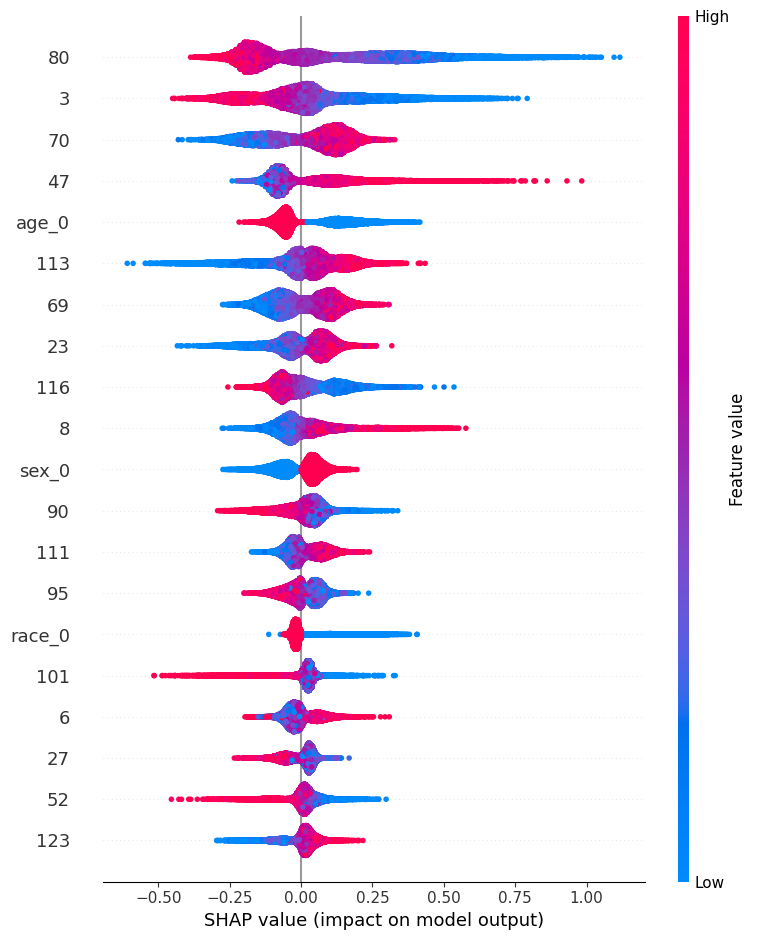

SHAP Summary Plot for Lung Opacity


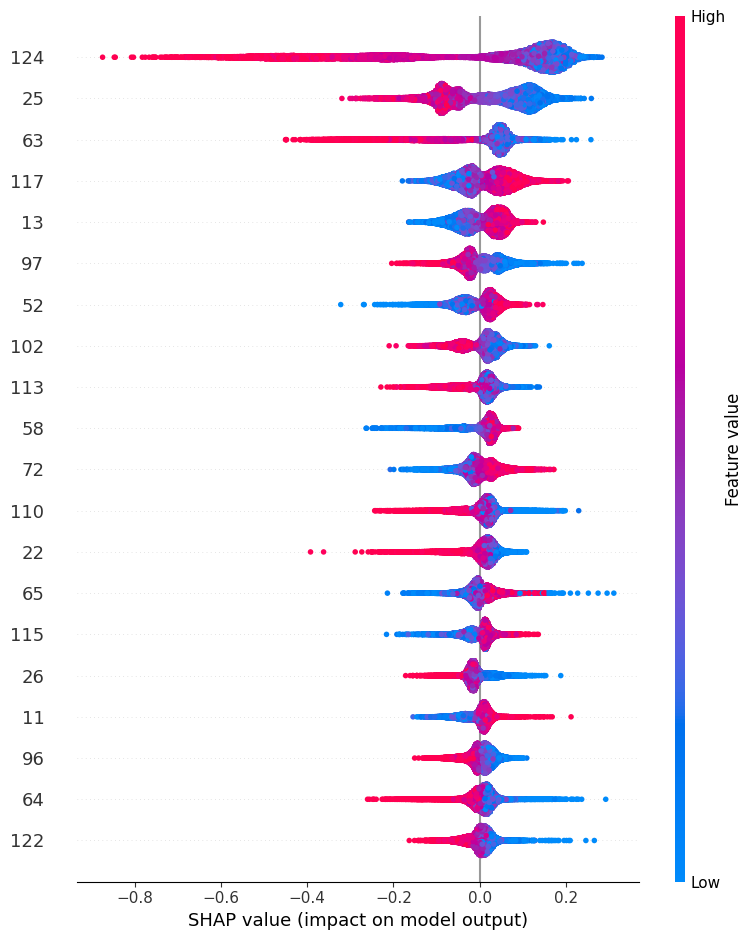

SHAP Summary Plot for Edema


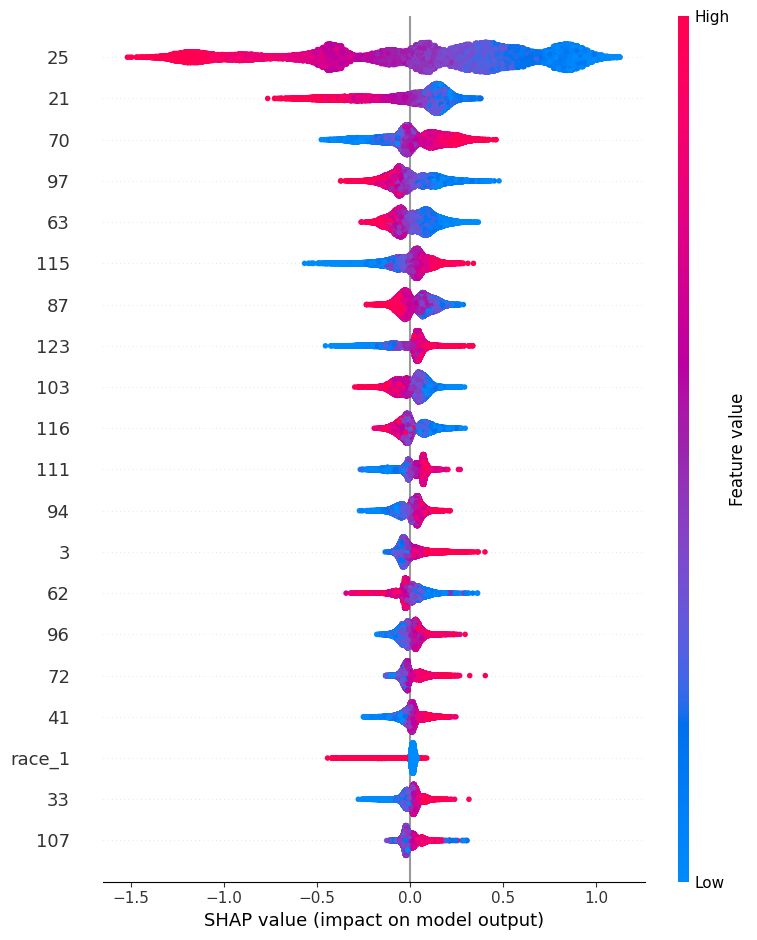

SHAP Summary Plot for Atelectasis


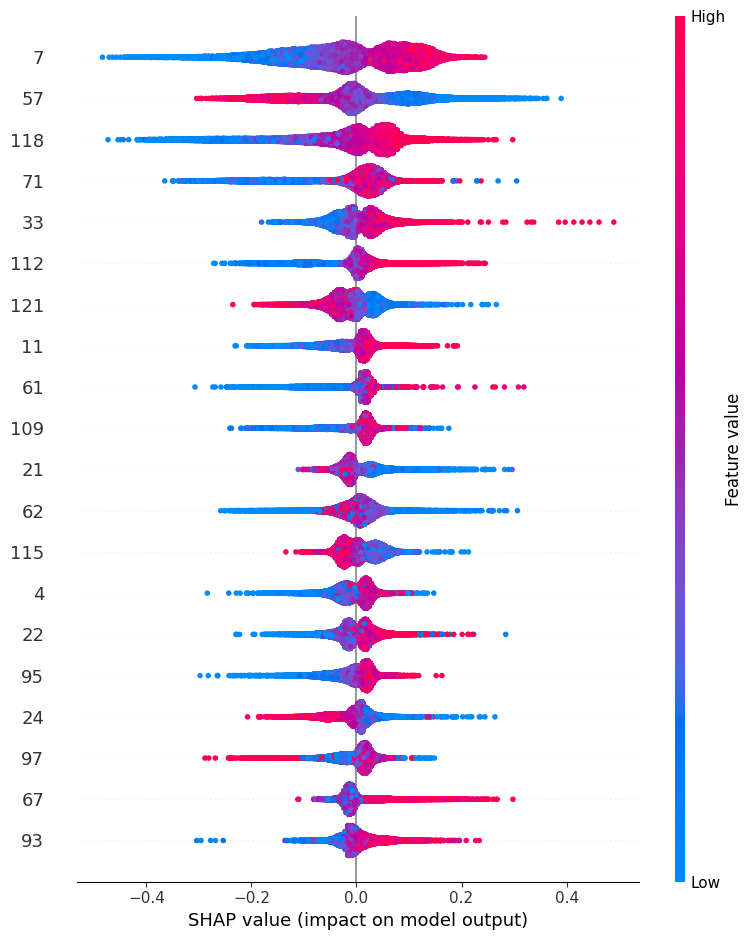

SHAP Summary Plot for Pneumothorax


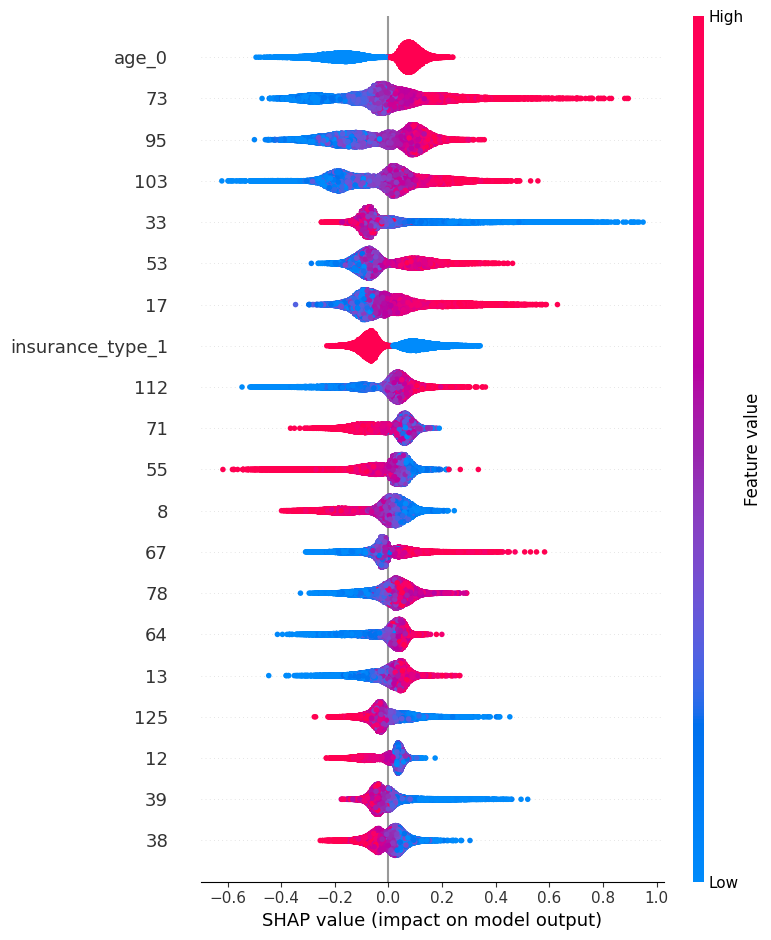

SHAP Summary Plot for Pleural Effusion


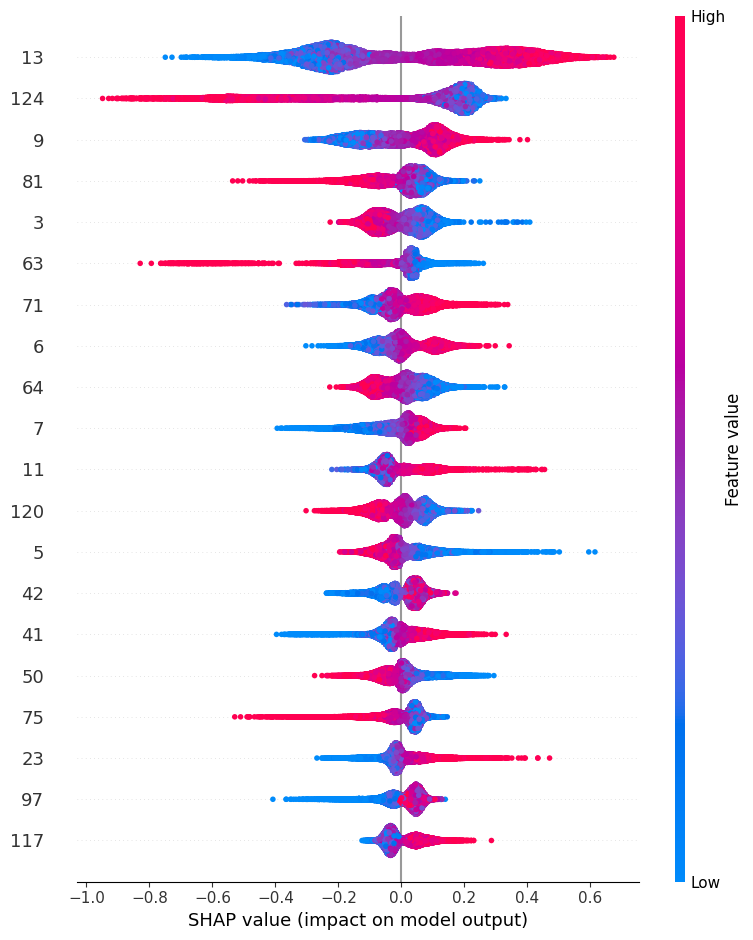

In [22]:
import pandas as pd
import numpy as np
from sklearn.multioutput import MultiOutputClassifier
from xgboost import XGBClassifier
import shap
import matplotlib.pyplot as plt

# Load latent embeddings
train_latent = np.load("train_latent.npy")
valid_latent = np.load("valid_latent.npy")
test_latent = np.load("test_latent.npy")

# Load labels
diseases = ['Cardiomegaly', 'Lung Opacity', 'Edema', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion']
y_train = train[diseases]
y_valid = valid[diseases]
y_test = test[diseases]

# Categorical variables
cath = ['age', 'sex', 'race', 'insurance_type']
train_cath = train[cath]
test_cath = test[cath]

# One-hot encode categorical variables
train_cath = pd.get_dummies(train_cath, columns=['age', 'sex', 'race', 'insurance_type'])
test_cath = pd.get_dummies(test_cath, columns=['age', 'sex', 'race', 'insurance_type'])
train_cath = train_cath.astype('int')
test_cath = test_cath.astype('int')

# Drop specific columns if needed
columns_to_remove = ['age_1', 'sex_1', 'race_2', 'insurance_type_2']
train_cath = train_cath.drop(columns=columns_to_remove, errors='ignore')
test_cath = test_cath.drop(columns=columns_to_remove, errors='ignore')

# Combine latent embeddings with categorical variables
x_train_subset = pd.concat([train_cath.reset_index(drop=True), pd.DataFrame(train_latent)], axis=1)
x_test_subset = pd.concat([test_cath.reset_index(drop=True), pd.DataFrame(test_latent)], axis=1)

# Feature names
feat_names = list(x_train_subset.columns)

# Define the train_model function
def train_model_with_shap(x_train, y_train, x_test, y_test, model, feature_names):
    """
    Train a MultiOutputClassifier with XGBoost and compute SHAP values for explanations.
    """
    # Initialize MultiOutputClassifier
    multi_output_model = MultiOutputClassifier(model)
    multi_output_model.fit(x_train, y_train)

    # Dictionary to hold the probabilistic predictions and SHAP values
    y_test_preds_proba = {}
    shap_values = {}

    # Check if the base model supports probability prediction
    if hasattr(model, "predict_proba"):
        for idx, estimator in enumerate(multi_output_model.estimators_):
            disease = diseases[idx]
            
            # Predict probabilities for the test set
            probs = estimator.predict_proba(x_test)
            y_test_preds_proba[disease] = probs[:, 1]  # Probabilities for the positive class
            
            # Compute SHAP values for the current disease
            explainer = shap.Explainer(estimator, x_train, feature_names=feature_names)
            shap_values[disease] = explainer(x_test)
    else:
        print("Model does not support probability predictions. SHAP values cannot be computed.")
        return None, None, None

    return multi_output_model, y_test_preds_proba, shap_values

# Initialize the XGBoost model
xgb_model = XGBClassifier(
    use_label_encoder=False,      
    eval_metric='logloss',   
    learning_rate=0.1,
    random_state=42
)

# Train the model and compute SHAP values
trained_model, y_test_preds_proba, shap_values = train_model_with_shap(
    x_train=x_train_subset, 
    y_train=y_train, 
    x_test=x_test_subset, 
    y_test=y_test, 
    model=xgb_model,
    feature_names=feat_names
)

# Visualize SHAP values for each disease
for disease_name in diseases:
    print(f"SHAP Summary Plot for {disease_name}")
    shap.summary_plot(shap_values[disease_name], feature_names=feat_names)
